# Instalando o PySpark
Requisitos:
* Java 8

In [ ]:
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz
# !tar xf spark-3.1.1-bin-hadoop2.7.tgz
# !pip install -q unidecode
# !pip install -q findspark

In [ ]:
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [ ]:
import numpy as np
import time

In [ ]:
from unidecode import unidecode
import findspark
findspark.init()
import pyspark.sql.functions as f
import pyspark.sql.types as t
from pyspark.sql import SparkSession
spark = SparkSession.builder \
                    .config('spark.executor.memory', '4G')\
                    .getOrCreate()

In [ ]:
spark

In [ ]:
#file_dir = '/content/drive/MyDrive/a3lab-pyspark/data/'
file_dir = 'data/'

# Leitura dos Dados

## Exportação dos Dados para o Colab

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

## Lendo Parquet

* Os arquivos Parquet são salvos de forma colunar, em contraste com o CSV que armazena baseado nas linhas. Assim, quando uma query é realizada é possível ignorar os dados não relevantes de maneira rápida e fácil, resultando em operações de agregação bem mais eficiente.
* Os dados salvos em Parquet tem diversos metadados preservados, incluíndo os tipos das colunas, o que garante eficiência e praticidade na escrita e leitura
* O Apache Parquet suporta dados estruturados de forma aninhada, como listas.
* O Parquet foi otimizado para processar dados particionados com volume na casa dos gigabytes para cada arquivo
* Os dados salvos em Parquet são comprimidos, de forma a ocupar menos espaço
* O Apache Parquet funciona bem com ferramentas como AWS Athena, Amazon Redshift Spectrum, Google BigQuery and Google Dataproc.

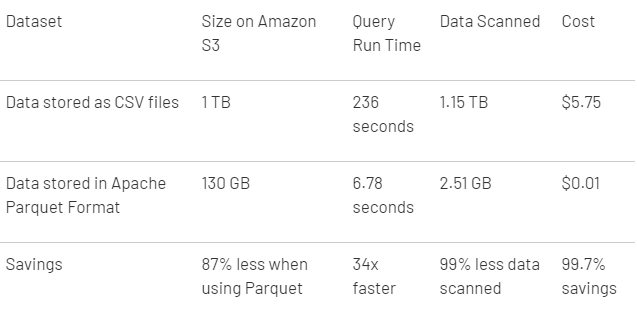

In [ ]:
df = spark.read.format('parquet').load(file_dir + 'df_cnpj')

In [ ]:
df_cnpj_example = spark.read.parquet(file_dir + 'df_cnpj_example')

In [ ]:
df_union_example = spark.read.parquet(file_dir + 'df_union_example')

In [ ]:
df_cnae_arrays = spark.read.parquet(file_dir + 'df_cnae_arrays')

## Lendo CSV


Opções mais comuns:
* header
* inferSchema
* sep
* encoding

In [ ]:
df_cnae = spark.read.format('csv').load(file_dir + 'df_cnae.csv')

In [ ]:
df_cnae.limit(5).toPandas()

### Opção de Correção 1

In [ ]:
df_cnae = spark.read.csv(file_dir + 'df_cnae.csv', header=True, sep=';', encoding='ISO-8859-1')
df_cnae.limit(5).toPandas()

### Opção de Correção 2

In [ ]:
df_cnae = (
    spark.read.format('csv')
    .option('header', 'true')
    .option('sep', ';')
    .option('encoding', 'ISO-8859-1')
    .load(file_dir + 'df_cnae.csv')
)
df_cnae.limit(5).toPandas()

### Opção de Correção 3

In [ ]:
df_cnae = (
    spark.read.format('csv')
    .options(header=True, sep=';', encoding='ISO-8859-1')
    .load(file_dir + 'df_cnae.csv')
)
df_cnae.limit(5).toPandas()

Obs: utilizando o método "options" podemos parametrizar melhor nossa função usando um dicionário

In [ ]:
args_dict = {
    'header': True,
    'sep': ';',
    'encoding': 'ISO-8859-1',
}

df_cnae = (
    spark.read.format('csv')
    .options(**args_dict)
    .load(file_dir + 'df_cnae.csv')
)
df_cnae.limit(5).toPandas()

### Definindo um schema
Da maneira trabalhosa:

In [ ]:
schema = t.StructType([t.StructField('cod_cnae', t.StringType()),
                       t.StructField('descricao_cnae', t.StringType()),])
schema

Da maneira simples e rápida:

In [ ]:
cols = ['cod_cnae', 'descricao_cnae']
schema = t.StructType([t.StructField(c, t.StringType()) for c in cols])
schema

In [ ]:
args_dict = {
    'header': True,
    'sep': ';',
    'encoding': 'ISO-8859-1'
}

df_cnae = (
    spark.read.format('csv')
    .options(**args_dict)
    .load(file_dir + 'df_cnae.csv', schema=schema)
)
df_cnae.limit(5).toPandas()

In [ ]:
df_cnae.printSchema()

## Olhando para os dados

In [ ]:
print('Número de Linhas: ', df.count(), '\n',
      'Número de Colunas: ', len(df.columns), '\n')
df.printSchema()

In [ ]:
df.limit(5).toPandas()

# Manipulação dos Dados

## Principais Operações

O design do pyspark.sql, obviamente, é baseado no SQL para o processamento de dados estruturados. Assim, muitas funções tem nomes parecidos e/ou funcionam da mesma forma que seus análogos em sql puro. 

Inclusive, é possível operar em um DataFrame utilizando somente SQL

### Seleção de Colunas

In [ ]:
df.select('cnpj', 'nome_fantasia', 'cnae_primario').limit(10).toPandas()

In [ ]:
cols = ['cnpj', 'nome_fantasia', 'cnae_primario']
df.select(cols).limit(10).toPandas()

In [ ]:
cols = ['nome_fantasia', 'cnae_primario']
df.select('cnpj', *cols).limit(10).toPandas()

Observações:
* Podemos realizar operações sobre colunas selecionadas. 
* A ordem em que as colunas são selecionadas é a ordem em que elas vão ser inseridas no DataFrame resultante.

In [ ]:
df.select('cnpj', 'cnae_primario', f.lower('nome_fantasia').alias('nome_fantasia')).limit(10).toPandas()

#### Selecionando valores distintos

In [ ]:
df.select('uf').distinct().toPandas()

### Filtros

Vamos utilizar a função `col()` para nos referirmos às colunas. Existem outras maneiras de fazermos isso, mas essa é a melhor forma. (justificativa adiante).

Operadores lógicos:
* e: &
* ou: |
* não: ~

Para fazer o filtro, pode ser utilizado tanto a função `filter()` como `where()`.

#### Filtros com uma condição

In [ ]:
(
    df.filter(f.col('situacao_cadastral') == 2)
    .select('cnpj', 'nome_fantasia', 'situacao_cadastral', 'cnae_primario', 'uf')
    .limit(5)
    .toPandas()
)

In [ ]:
(
    df.where(f.col('situacao_cadastral') == 2)
    .select('cnpj', 'nome_fantasia', 'situacao_cadastral', 'cnae_primario', 'uf')
    .limit(5)
    .toPandas()
)

#### Filtros com duas ou mais condição
Cada uma das condições deve estar entre parênteses e separada por um operador lógico. Naturalmente, é possível também "aninhar" condições, seguindo essa mesma lógica

In [ ]:
(
    df.filter((f.col('situacao_cadastral') == 2) & (f.col('uf') == "SP"))
    .select('cnpj', 'nome_fantasia', 'situacao_cadastral', 'cnae_primario', 'uf')
    .limit(5)
    .toPandas()
)

In [ ]:
(
    df.filter((f.col('situacao_cadastral') == 2) & ((f.col('uf') == "SP")) | (f.col('uf') == "MG"))
    .select('cnpj', 'nome_fantasia', 'situacao_cadastral', 'cnae_primario', 'uf')
    .limit(15)
    .toPandas()
)

In [ ]:
(
    df.filter((f.col('situacao_cadastral') == 2) & (f.col('uf').isin('SP', 'MG')))
    .select('cnpj', 'nome_fantasia', 'situacao_cadastral', 'cnae_primario', 'uf')
    .limit(15)
    .toPandas()
)

#### Filtros Utilizando SQL

In [ ]:
(
    df.filter('situacao_cadastral = 2')
    .select('cnpj', 'nome_fantasia', 'situacao_cadastral', 'cnae_primario', 'uf')
    .limit(5)
    .toPandas()
)

In [ ]:
(
    df.filter('situacao_cadastral = 2 and (uf in ("SP", "MG"))')
    .select('cnpj', 'nome_fantasia', 'cnae_primario', 'situacao_cadastral', 'uf')
    .limit(15)
    .toPandas()
)

#### Observações
Quando nos referimos às colunas por meio da função `col()`, temos acesso à diversos métodos das colunas que podem ser utilizados para auxliar na filtragem do DataFrame. Alguns deles são:
* `isin()`: checa se a coluna contém os valores listados na função.
* `contains()`: utilizado para verificar se uma coluna de texto contém algum padrão especificado (não aceita regex). Aceita uma outra coluna de texto.
* `like()`: utilizado para verificar se uma coluna de texto contém algum padrão especificado (não aceita regex). Funciona de forma similar ao "LIKE" do SQL.
* `rlike()`: utilizado para verificar se uma coluna de texto contém algum padrão especificado (**aceita regex**). Funciona de forma similar ao "RLIKE" do SQL.
* `startswith()`: utilizado para verificar se uma coluna de texto começa com algum padrão especificado (**aceita regex**).
* `endswith()`: utilizado para verificar se uma coluna de texto termina com algum padrão especificado (**aceita regex**).
* `between()`: checa se os valores da coluna estão dentro do intervalo especificado. Os dois lados do intervalo são inclusivos.
* `isNull()`: retorna True se o valor da coluna é nulo
* `isNotNull()`: retorna True se o valor da coluna não é nulo

Outros métodos úteis:
* `alias()/name()`: usado para renomear as colunas em operações como select() e agg()
* `astype()/cast()`: usado para mudar o tipo das colunas. Aceita tanto um string como um tipo especificado pelo módulo pyspark.sql.types
* `substr()`: utilizado para cortar um string com base em índices dos caracteres 

In [ ]:
(
    df.filter(f.col('nome_fantasia').isNotNull())
    .select('cnpj', 'nome_fantasia', 'cnae_primario', 'situacao_cadastral', 'uf')
    .limit(5)
    .toPandas()
)

In [ ]:
(
    df.filter(f.col('nome_fantasia').like('%SUPERMERCADO%'))
    .select('cnpj', 'nome_fantasia', 'cnae_primario', 'situacao_cadastral', 'uf')
    .limit(5)
    .toPandas()
)

### Ordenando o DataFrame

A ordenação do DataFrame pode ser feita utilizando as funções `orderBy()` ou `sort()`. Algumas funções auxiliares importante para serem usadas ao ordenar:
* `asc()`: ordena a coluna de forma ascendente (default)
* `desc()`ordena a coluna de forma decrescente
* `asc_nulls_first() / desc_nulls_first()`: ordena a coluna de forma ascendente e decrescente, respectivamente, mantendo os campos nulos primeiro
* `asc_nulls_last() / desc_nulls_last()`: ordena a coluna de forma ascendente e decrescente, respectivamente, mantendo os campos nulos por último

In [ ]:
df.select('uf').distinct().orderBy('uf').toPandas()

In [ ]:
(
    df.select('cnpj', 'nome_fantasia')
    .limit(10)
    .orderBy(f.asc_nulls_last('nome_fantasia'))
    .toPandas()
)

### Renomeando Colunas

Para renomear colunas, é utilizada a função `withColumnRenamed()`, da seguinte forma:

```
df.withColumnRenamed(`nome_antigo`, 'nome_novo')
```

In [ ]:
(
    df.select('cnpj', 'nome_fantasia', 'cnae_primario', 'situacao_cadastral', 'uf')
    .withColumnRenamed('uf', 'estado')
    .limit(5)
    .toPandas()
)

In [ ]:
(
    df.withColumnRenamed('uf', 'estado')
    .select('cnpj', 'nome_fantasia', 'cnae_primario', 'situacao_cadastral', 'estado')
    .limit(5)
    .toPandas()
)

In [ ]:
(
    df.select('cnpj', 'nome_fantasia', 'cnae_primario', 'situacao_cadastral', f.col('uf').alias('estado'))
    .limit(5)
    .toPandas()
)

### Criando e Alterando Colunas

Para criar ou alterar colunas, é utilizada a função `withColumn()`, da seguinte forma:

```
df.withColumn(`nome_da_coluna`, {nova especificacao de coluna})
```

#### Principios Basicos

In [ ]:
 df.select('cnpj', 'nome_fantasia', 'cnae_primario', 'situacao_cadastral', 'uf').dtypes

In [ ]:
(
    df.withColumn('situacao_cadastral', f.col('situacao_cadastral').cast('integer')) # também poderíamos usar .cast(t.IntegerType())
    .select('cnpj', 'nome_fantasia', 'cnae_primario', 'situacao_cadastral', 'uf')
    .dtypes 
)

In [ ]:
(
    df.select('cnpj', 'nome_fantasia', 'cnae_primario', 'situacao_cadastral', 'uf')
    .withColumn('situacao_cadastral', f.col('situacao_cadastral').cast('integer'))
    .withColumn('uf_lower', f.lower(f.col('nome_fantasia')))
    .limit(5)
    .toPandas()
)

#### Exemplos com as funções mais utilizadas

##### Valores numéricos

* `round()`: arredonda o valor numérico
* `ceil()`: arredonda o valor numérico para o maior inteiro mais próximo
* `floor()`: arredonda o valor numérico para o menor inteiro mais próximo
* `sqrt()`: retorna a raiz quadrada do valor
* `exp()`: retorna a exponencial do valor
* `log()`: retorna a logaritmo natural do valor
* `log10()`: retorna a logaritmo na base 10 do valor
* `greatest()`: retorna o maior valor dentre os valores das colunas. Análogo ao `max()`, mas entre colunas
* `least()`: retorna o menor valor dentre os valores das colunas. Análogo ao `min()`, mas entre colunas

In [ ]:
df.select('cnpj', 'nome_fantasia', 'cnae_primario').limit(5).toPandas()

In [ ]:
(
    df.select('cnpj', 'nome_fantasia', 'cnae_primario')
#     .withColumn('numeric_col1', f.randn())
#     .withColumn('numeric_col2', f.randn())
#     .withColumn('numeric_col3', f.randn())
#     .withColumn('dummy_division', f.col('numeric_col1') / f.col('numeric_col2'))
#     .withColumn('round_example', f.round(f.col('dummy_division'), 3))
#     .withColumn('ceil_example', f.ceil(f.col('dummy_division')))
#     .withColumn('floor_example', f.floor(f.col('dummy_division')))
#     .withColumn('greatest_example', f.greatest(f.col('numeric_col1'), f.col('numeric_col2'), f.col('numeric_col3')))
#     .withColumn('least_example', f.least(f.col('numeric_col1'), f.col('numeric_col2'), f.col('numeric_col3')))
    .limit(5)
    .toPandas()
)

##### Strings

* `upper()`: retorna o string em letras maiúsculas
* `lower()`: retorna o string em letras minúsculas
* `initcap()`: retorna a primeira letra de cada palavra no string em letras maiúsculas
* `trim()`: retira os espaços em branco do início e do final do string
* `ltrim() / rtrim()`: retira os espaços em branco do início e do final do string, respectivamente
* `lpad() / rpad()`: acrescenta um caractere no início e no final do string, respectivamente, até que o string tenha um determinado comprimento
* `length()`: retorna o comprimento do string, em quantidade de caracteres
* `split()`: quebra o string a partir de um padrão e retorna um array com os string resultantes
* `concat()`: concatena uma ou mais colunas de string
* `concat_ws()`: concatena uma ou mais colunas de string, com um separador entre elas
* `regexp_extract()`: retorna um match no string a partir de um padrão regex
* `regexp_replace()`: substitui um mtach no strinf a partir de um padrão regex com outros caracteres
* `substring()`: retorna os caracteres do string que estão entre dos indices especificados. Análogo a `f.col().substring()`

In [ ]:
df.select('cnpj', 'nome_fantasia', 'cnae_primario', 'correio_eletronico', ).limit(5).toPandas()

In [ ]:
(
    df.select('cnpj', 'nome_fantasia', 'cnae_primario', 'correio_eletronico', )
    .filter('nome_fantasia is not null')
#     .withColumn('email_lower', f.lower(f.col('correio_eletronico')))
#     .withColumn('nome_fantasia_new', f.trim(f.initcap(f.col('nome_fantasia'))))
#     .withColumn('primeira_palavra_nome', f.split(f.col('nome_fantasia_new'), ' ')[0])
#     .withColumn('dominio_email', f.regexp_extract(f.col('email_lower'), '(?<=@).+', 0))
#     .withColumn('dominio_gmail', f.regexp_replace(f.col('dominio_email'), '.+(?=\.com)', 'gmail'))
    .limit(5)
    .toPandas()
)

##### Datas

* `add_months()`: retorna a data depois de adicionar "x" meses
* `months_between()`: retorna a diferença entre duas datas em meses
* `date_add()`: retorna a data depois de adicionar "x" dias
* `date_sub()`: retorna a data depois de subtrair "x" dias
* `next_day()`: retorna o dia seguinte de alguma data
* `datediff()`: retorna a diferença entre duas datas em dias
* `current_date()`: retorna a data atual
* `dayofweek() / dayofmonth() / dayofyear()`: retorna o dia relativo à semana, ao mês e ao ano, respectivamente
* `weekofyear()`: retorna a semana relativa ao ano
* `second() / minute() / hour()`: retorna os segundos, os minutos e as horas de uma coluna de date-time, respectivamente
* `month() / year()`: retorna o mês e o ano de uma coluna de data, respectivamente
* `last_day()`: retorna o último dia do mês do qual a data considerada pertence
* `to_date()`: transforma a coluna no tipo data (t.DateType())
* `trunc()`: formata a data para a unidade especificada
    * `year`: "{ano}-01-01"
    * `month`: "{ano}-{mes}-01"

In [ ]:
df.select('cnpj', 'nome_fantasia', 'cnae_primario', 'data_inicio_atividades').limit(5).toPandas()

In [ ]:
(
    df.select('cnpj', 'nome_fantasia', 'cnae_primario', 'data_inicio_atividades')
#     .withColumn('data_abertura', f.concat_ws('-', 
#                                              f.col('data_inicio_atividades').substr(1, 4), 
#                                              f.col('data_inicio_atividades').substr(5, 2), 
#                                              f.col('data_inicio_atividades').substr(7, 2)
#                                             )
#                )
#     .withColumn('mes', f.month(f.col('data_abertura')))
#     .withColumn('ano', f.year(f.col('data_abertura')))
#     .withColumn('data_mes', f.trunc(f.col('data_abertura'), 'month'))
#     .withColumn('ultimo_dia_mes', f.last_day(f.col('data_abertura')))
#     .withColumn('hoje', f.current_date())
#     .withColumn('idade_empresa_dias', f.datediff(f.col('hoje'), f.col('data_abertura')))
#     .withColumn('idade_empresa_meses', f.floor(f.months_between(f.col('hoje'), f.col('data_abertura'))))
#     .withColumn('idade_empresa_anos', f.floor(f.datediff(f.col('hoje'), f.col('data_abertura')) / 365))
    .limit(5)
    .toPandas()
)

##### Arrays

* `array()`: constrói um array com as colunas selecionadas
* `flatten()`: transforma um array de arrays em um unico array
* `explode()`: retorna uma nova linha para cada elemento no array 
* `size()`: retorna o número de elementos no array
* `sort_array()`: orderna os elementos do array, de forma crescente ou decrescente
* `reverse()`: reverte a ordem dos elementos de um array
* `array_distinct()`: remove elementos duplicados do array
* `array_contains()`: verifica se o array contém o elemento especificado
* `arrays_overlap()`: partir de 2 colunas de arrays, verifica se elas tem algum elemento em comum, retornando True ou False
* `array_union()`: a partir de 2 colunas de arrays, retorna um array com os elementos unidos das duas colunas, sem duplicatas
* `array_except()`: a partir de 2 colunas de arrays, retorna um array com os elementos que estão em uma coluna mas não estão na outra, sem duplicatas
* `array_intersect()`: a partir de 2 colunas de arrays, retorna um array com os elementos que nas duas colunas, sem duplicatas
* `array_join()`: retorna um string após concatenar os elementos do array usando o delimitador especificado
* `array_max() / array_min()`: retorna o máximo e o mínimo valor do array, respectivamente
* `array_remove()`: remove todos os elementos do array que são iguais ao valor especificado


In [ ]:
df_cnae_arrays.limit(5).toPandas()

In [ ]:
(
    df_cnae_arrays.withColumn('size', f.size(f.col('array_cnae')))
#     .withColumn('flatten_array', f.flatten(f.col('array_cnae')))
#     .withColumn('primeiro_array', f.col('array_cnae')[0])
#     .withColumn('segundo_array', f.col('array_cnae').getItem(1))
#     .withColumn('string_pri_array', f.array_join(f.col('primeiro_array'), ' - '))
#     .withColumn('overlap_pri_seg_array', f.arrays_overlap(f.col('primeiro_array'), f.col('segundo_array')))
    .limit(5)
    .toPandas()
)

In [ ]:
(
    df_cnae_arrays.withColumn('array_cnae', f.explode(f.col('array_cnae')))
#     .withColumn('cod_cnae', f.col('array_cnae').getItem(0))
#     .withColumn('descricao_cnae', f.col('array_cnae').getItem(1))
    .limit(5)
    .toPandas()
)

Aplicação da função explode

In [ ]:
(
    df_cnae.filter('cod_cnae = "4611700"')
#     .withColumn('valores', f.sequence(f.lit(1), f.lit(10)))
#     .withColumn('valores', f.explode(f.col('valores')))
    .toPandas()
)

##### Colunas a Partir de Constantes

Para gerar valores constantes, devemos utilizar a função `lit()`

In [ ]:
(
    df.select('cnpj', 'nome_fantasia', 'cnae_primario', 'situacao_cadastral', 'uf', 'data_inicio_atividades')
    .withColumn('constante', 13)
    .limit(5)
    .toPandas()
)

In [ ]:
(
    df.select('cnpj', 'nome_fantasia', 'cnae_primario', 'situacao_cadastral', 'uf', 'data_inicio_atividades')
    .withColumn('constante', f.lit(13))
    .limit(5)
    .toPandas()
)

In [ ]:
(
    df.select('cnpj', 'nome_fantasia', 'cnae_primario', 'situacao_cadastral', 'uf', 'data_inicio_atividades')
    .withColumn('month_date', f.concat_ws('-', f.col('data_inicio_atividades').substr(1, 4), f.col('data_inicio_atividades').substr(5, 2), f.lit('01')))
    .limit(5)
    .toPandas()
)

In [ ]:
alguns_cnaes = ['5611204', '2539001', '4752100', '4120400']
(
    df.select('cnpj', 'nome_fantasia', 'cnae_primario', 'situacao_cadastral', 'uf', 'data_inicio_atividades')
    .withColumn('lista_cnaes', f.array([f.lit(cnae) for cnae in alguns_cnaes]))
    .limit(5)
    .toPandas()
)

##### Colunas Condicionais

As colunas condicionais no pyspark são construídas de forma parecida com um "CASE WHEN" do sql. Segue a seguinte forma:

```
df1.withColumn('column', f.when({primeira condicao}, {resultado se verdadeiro})
                          .when({segunda condicao}, {resultado se verdadeiro})
                          (...)
                          .otherwise({resultado se nenhuma das condicoes for verdadeira})
    )
```

Qualquer expressão lógica é válida como condição, inclusive aquelas usadas para realizar filtros. 

**Obs**: Quando os resultados são colunas, devem ser especificados com a função `col()`. Não é necessário utilizar a função `lit()` para retornar constantes não presentes em colunas.

In [ ]:
df.select('cnpj', 'nome_fantasia', 'cnae_primario', 'id_matriz', 'situacao_cadastral').limit(5).toPandas()

In [ ]:
(
    df.select('cnpj', 'nome_fantasia', 'cnae_primario', 'id_matriz', 'situacao_cadastral', 'uf', 'data_inicio_atividades')
#     .withColumn('situacao_cnpj', f.when(f.col('situacao_cadastral') == 2, 'Ativa').otherwise('Não Ativa'))
#     .withColumn('descricao_matriz', f.when(f.col('id_matriz') == 1, 'Matriz')
#                               .when(f.col('id_matriz') == 2, 'Filial')
#                               .otherwise(None)
#                )
#     .withColumn('nome_fantasia2', f.when(f.col('nome_fantasia').isNull(), 'sem nome').otherwise(f.col('nome_fantasia')))
#     .withColumn('idc_nome', f.when(f.col('nome_fantasia').isNotNull(), 1).otherwise(0))
    .limit(5)
    .toPandas()
)

### User Defined Functions (UDFs)

Em algumas situações é necessário criar/alterar uma coluna utilizando uma operação não implementada na biblioteca padrão. Para isso, é possível utilzar funções definidas pelo usuário (UDFs) por meio da função `udf()`.

**Importante**: As udfs não são otimizadas para serem executadas em paralelo, e por isso podem representar um gargalo na na aplicação.

In [ ]:
unidecode('àáâçéõü')

In [ ]:
def unidecode_function(string):
    if string is None:
        return None
    else:
        return unidecode(string)

unidecode_udf = f.udf(unidecode_function, returnType=t.StringType())

In [ ]:
(
    df_cnae.filter(f.col('descricao_cnae').rlike('à|á|â|ç|é|õ|ü'))
    .withColumn('cleaned_string', unidecode_udf(f.col('descricao_cnae')))
    .limit(5)
    .toPandas()
)

In [ ]:
del unidecode_udf

In [ ]:
@f.udf(returnType=t.StringType())
def unidecode_udf(string):
    if string is None:
        return None
    else:
        return unidecode(string)

In [ ]:
(
    df_cnae.filter(f.col('descricao_cnae').rlike('à|á|â|ç|é|õ|ü'))
    .withColumn('cleaned_string', unidecode_udf(f.col('descricao_cnae')))
    .limit(5)
    .toPandas()
)

### Agregação e Agrupamento

O agrupamento dos DataFrames é feito por meio da função **`groupby()`**. Essa função deve ser sucedida pela função de agregação `agg()`, de pivotação `pivot()` ou `count()`. 

---

A função **`agg()`** aplica uma função de agregação no DataFrame. Se precedida por `groupby()`, realiza a agregação dentro dos grupos esabelecidos.
Algumas das funções de agregação mais comuns:
* `sum()`: retorna a soma os valores da coluna
* `sumDistinct()`: retorna a soma os valores distintos da coluna
* `max() / min()`: retorna o mínimo e o máximo da coluna, respectivamente
* `avg() / mean()`: retorna a média dos valores da coluna
* `percentile_approx()`: retorna o percentil da coluna, comaproximação. Para trazer a mediana exata, usar: `percentile_approx(f.col('column'), 0.5, lit(1000000))`
* `stddev()`: retorna o desvio padrão dos valores da coluna
* `count()`: retorna a contagem de linhas
* `countDistinct()`: retorna a contagem de valores distintos da coluna
* `first() / last()`: retorna o primeiro e o último valor da coluna no agrupamento, respectivamente. Interessante de ser utilizada em conjunto com o argumento `ignoreNulls=True`.
* `collect_list()`: retorna os valores do agrupamento em uma lista, com duplicações
* `collect_set()`: retorna os valores do agrupamento em uma lista, sem duplicações (desordenado)

**Obs**: O spark ignora os valores nulos para calcular os agrupamentos, com exceção da função `count()`.

---

A função **`pivot`** é utilizada para passar valores de uma linha para as colunas, realizando uma agregação. Deve ser sucedido por uma função de agregação utilizando `agg()`. Pode utilizar qualquer uma das funções de agregação anteriores.



In [ ]:
df_cnae_agg = (
    df_cnae.withColumn('cod_cnae_macro', f.col('cod_cnae').substr(1, 2))
    .withColumn('word_count', f.size(f.split(f.col('descricao_cnae'), ' ')))
)

In [ ]:
df_cnae_agg.limit(5).toPandas()

In [ ]:
df_cnae.agg(f.countDistinct('cod_cnae').alias('count_distinct'),).toPandas()

In [ ]:
df_cnae_agg.agg(f.sum('word_count').alias('total_words'),).toPandas()

#### Agrupamento

In [ ]:
(
    df_cnae_agg.groupby('cod_cnae_macro')
    .count()
    .orderBy('cod_cnae_macro')
    .toPandas()
)

In [ ]:
(
    df_cnae_agg.groupby('cod_cnae_macro')
    .agg(f.collect_list(f.col('cod_cnae')).alias('lista_cnae'))
    .orderBy('cod_cnae_macro')
    .toPandas()
)

In [ ]:
(
    df_cnae_agg.groupby('cod_cnae_macro')
    .agg(f.mean(f.col('word_count')).alias('mean_words_descricao'))
    .orderBy('cod_cnae_macro')
    .toPandas()
)

#### Pivotação

In [ ]:
df_cnpj_example.limit(5).toPandas()

In [ ]:
(
    df_cnpj_example.withColumn('cod_cnae_macro', f.col('cnae_primario').substr(1, 2))
    .groupby('cod_cnae_macro')
    .pivot('uf')
    .count()
    .orderBy('cod_cnae_macro')
    .limit(5)
    .toPandas()
)

### Window Functions

Window functions são funções que realizam cálculos similares à uma agregação, mas que não resultam em um DataFrame agregado. Ao invés disso, os resultados são colocados em uma nova coluna, segundo a partição (ou agrupamento) especificado. 
Exemplos mais comuns:
* `row_number()`
* `rank() / dense_rank() / percent_rank()`
* `lag()`
* `cume_dist()`
* `collect_list() / collect_set()`
* Demais funções de agregação, com exceção de `countDistinct()`

Para usar as funções dessa forma, devemos criar uma janela (window) da seguinte forma:

```{python}
from pyspark.sql.window import Window
w = Window.partitionBy({columns}).orderBy({columns}).rowsBetween({lower}, {upper})
```

* **`partitionBy()`**: agrupamento em que os cálculos serão realizados. É análogo ao `groupBy()`.
* **`orderBy`**: algumas funções como `row_number()` e `lag()` dependem da ordenação das linhas do agrupamento. Essa função é usada para especificar essa ordem.
* **`rowsBetween()`**: esse método é usado para especificar janelas deslizantes. A partir dele é possível definir um intervalo de linhas, relativas à linha atual, em que a função vai ser aplicada. Caso isso não seja especificado, as operações são realizadas em todo o grupo. Muito útil para construir **médias móveis**. Os seguintes objetos ajudam na constrção desse intervalo:
  * `Window.currentRow`: define a linha para qual o valor está sendo calculado como um dos limites de cálculo
  * `Window.unboundedPreceding`: define que não há limites para as linhas anteriores à linha para qual o valor está sendo calculado, isto é, a função irá considerar todas as linhas do grupo que já passaram. Deve ser usado no primeiro argumento (start).
  * `Window.unboundedFollowing`: define que não há limites para as linhas posteriores à linha para qual o valor está sendo calculado, isto é, a função irá considerar todas as linhas do grupo que ainda não passaram. Deve ser usado no segundo argumento (end).

Depois disso, basta utilizar a função `over()` para indicar que aquela função deve ser realizada na janela.  Exemplo:
```
df.withColumn('rn', f.row_number().over(w))
```


In [ ]:
from pyspark.sql.window import Window

In [ ]:
w = Window.partitionBy('cod_cnae_macro').orderBy(f.desc('word_count'))
(
    df_cnae_agg.withColumn('rn', f.row_number().over(w))
    .filter('cod_cnae_macro in ("43", "45")')
    .orderBy('cod_cnae_macro', 'rn')
    .toPandas()
)

In [ ]:
w = Window.partitionBy('cod_cnae_macro')
(
    df_cnae_agg.withColumn('total_words', f.sum(f.col('word_count')).over(w))
    .withColumn('relative_word_count', f.col('word_count') / f.col('total_words'))
    .filter('cod_cnae_macro in ("43")')
    .orderBy(f.desc('word_count'))
    .toPandas()
)

#### Usando uma Window para calcular os distintos

In [ ]:
w = Window.partitionBy('cod_cnae_macro')
(
    df_cnae_agg.withColumn('lista_cnae', f.countDistinct(f.col('cod_cnae')).over(w))
    .limit(5)
    .orderBy('cod_cnae_macro')
    .toPandas()
)

In [ ]:
w = Window.partitionBy('cod_cnae_macro')
(
    df_cnae_agg.withColumn('lista_cnae', f.collect_set(f.col('cod_cnae')).over(w))
    .limit(5)
    .orderBy('cod_cnae_macro')
    .toPandas()
)

In [ ]:
w = Window.partitionBy('cod_cnae_macro')
(
    df_cnae_agg.withColumn('lista_cnae', f.collect_set(f.col('cod_cnae')).over(w))
    .withColumn('cnae_distintos', f.size(f.col('lista_cnae')))
    .limit(5)
    .orderBy('cod_cnae_macro')
    .toPandas()
)

In [ ]:
(
    df_cnae_agg.groupby('cod_cnae_macro')
    .agg(f.countDistinct(f.col('cod_cnae')).alias('cnae_distintos'))
    .orderBy('cod_cnae_macro')
    .limit(10)
    .toPandas()
)

#### Usando Windows para evitar Joins

In [ ]:
df_cnpj_example.limit(5).toPandas()

Objetivo: Empresas de MG com a que abriram mais recentemente em cada CNAE

Caminho natural:
```
df1 = df.groupby('uf', 'cnae_primario').agg(f.max(f.col('data_abertura').alias('data_abertura'))
df2 = df.join(df1, ['uf', 'cnae_primario', 'data_abertura'])
```
Alternativa:

In [ ]:
w = Window.partitionBy('uf', 'cnae_primario')
(
    df_cnpj_example.withColumn('max_data', f.max(f.col('data_abertura')).over(w))
    .filter('data_abertura = max_data and uf = "MG"')
    .orderBy('cnae_primario')
    .limit(20)
    .toPandas()
)

### Joins

Os joins no pyspark são especificados pela função `join()`, da seguinte forma:

```
df1.join(df2, {key_columns}, {join_type})
```

* `key_columns`: colunas que vão ser utilizadas para fazer a junção das tabelas. Pode ser especificada como
    * Um único string -> só uma coluna é chave, mesmos nomes nas duas tabelas
    * Uma lista de string ou de colunas (`col()`) -> mais de uma coluna é chave, mesmos nomes nas duas tabelas
    * Com nomes diferentes, é necessário fazer uma especificação do tipo: `f.col(column1) == f.col(column2)`, em que a coluna da esquerda está no DataFrame da esquerda e analogamente a coluna da direita está no DataFrame da direita. Caso existam mais de uma coluna como chave, essas especificações devem ser colocadas em uma lista.
* `join_type`: o tipo de join a ser realizado. As opções são:
    * `inner (default)`: INNER JOIN do SQL
    * `outer / full / fullouter / full_outer`: : FULL OUTER JOIN do SQL
    * `left / leftouter / left_outer`: : LEFT JOIN do SQL
    * `right / rightouter / right_outer`: : RIGHT JOIN do SQL
    * `semi / leftsemi / left_semi`: realiza um LEFT JOIN do SQL e retorna somente as colunas do DataFrame da esquerda que também estão no DataFrame da Direita
    * `anti / leftanti / left_anti`: realiza um LEFT JOIN do SQL e retorna somente as colunas do DataFrame da esquerda que não estão no DataFrame da Direita

In [ ]:
(
    df_cnpj_example.join(df_cnae, f.col('cnae_primario') == f.col('cod_cnae'))
    .limit(5)
    .toPandas()
)

In [ ]:
(
    df_cnpj_example.withColumnRenamed('cnae_primario', 'cod_cnae')
    .join(df_cnae, 'cod_cnae')
    .limit(5)
    .toPandas()
)

#### Utilizando semi e anti join

In [ ]:
df_example_filtered = (
    df_cnpj_example.withColumnRenamed('cnae_primario', 'cod_cnae')
    .filter('uf = "MG" and data_abertura >= "2021-01-01"')
)

In [ ]:
df_example_filtered.select('cod_cnae').distinct().count()

In [ ]:
df_cnae.count()

In [ ]:
(
    df_cnae.join(df_example_filtered, 'cod_cnae', 'left_semi')
    .count()
)

In [ ]:
(
    df_example_filtered.join(df_cnae, 'cod_cnae', 'left_anti')
    .select('cod_cnae').distinct()
    .toPandas()
)

In [ ]:
df_cnae.filter('cod_cnae = "0111302"').toPandas()

In [ ]:
(
    df_example_filtered.withColumn('cod_cnae', f.lpad(f.col('cod_cnae'), 7, '0'))
    .join(df_cnae, 'cod_cnae', 'left_anti')
    .select('cod_cnae').distinct()
    .toPandas()
)

### Union

Existem três formas de unir DataFrames no pyspark:
* `union() / unionAll()`: empilha os DataFrames, preservando linhas duplicadas. As colunas são unidas por posição, e por isso a ordem delas deve ser a mesma entre os dois DFs.
* `unionByName()`: empilha os DataFrames, preservando linhas duplicadas. As colunas são unidas por nome, e por tanto não precisam estar ordenadas da mesma forma

In [ ]:
df_union_example.limit(5).toPandas()

In [ ]:
df_union_example.count()

In [ ]:
df_union_example.union(df_union_example).count()

In [ ]:
df_union_example.union(df_union_example).distinct().count()

In [ ]:
df2 = df_union_example.select(df_union_example.columns[::-1])

In [ ]:
df2.limit(5).toPandas()

In [ ]:
df_union_example.union(df2).filter('cnpj_dv like "%ERCRP@TERRA.COM.BR%"').limit(5).toPandas()

In [ ]:
df_union_example.unionByName(df2).filter('cnpj_dv like "%ERCRP@TERRA.COM.BR%"').limit(5).toPandas()

### Salvando os Dados

Para a escrita dos dados, importante ressaltar a seguinte opção
* mode: especifica o comportamento da operação de escrita dos dados, caso eles já existam
  * append: Anexa o conteudo do DataFrame aos dados existentes.
  * overwrite: Sobrescreve dados existentes.
  * ignore: Ignora silenciosamente essa oprecao se os dados ja existirem.
  * error or errorifexists (default): Retorna erro se os dados ja existirem.

In [ ]:
df_save = (
    df.filter('situacao_cadastral = 2')
     .withColumn('data_abertura', f.concat_ws('-', 
                                             f.col('data_inicio_atividades').substr(1, 4), 
                                             f.col('data_inicio_atividades').substr(5, 2), 
                                             f.col('data_inicio_atividades').substr(7, 2)
                                            )
               )
    .withColumn('cnae_primario', f.lpad(f.col('cnae_primario'), 7, '0'))
    .select('cnpj', 'nome_fantasia', 'cnae_primario', 'situacao_cadastral', 'uf', 'data_abertura')
)

In [ ]:
df_save.limit(5).toPandas()

In [ ]:
df_save.write.format('parquet').save(file_dir + 'df_cnpj_example2')

In [ ]:
spark.read.parquet(file_dir + 'df_cnpj_example2').limit(5).toPandas()

In [ ]:
spark.read.parquet(file_dir + 'df_cnpj_example').limit(5).toPandas()

In [ ]:
#df_save.write.format('parquet').save(file_dir + 'df_cnpj_example', mode='overwrite')

# Características Importantes do Spark

## Imutabilidade dos DataFrames

### O porquê de utilizar  a função `col()`

In [ ]:
col = 'data_inicio_atividades'
(
    df.select('cnpj', 'nome_fantasia', 'cnae_primario', 'situacao_cadastral', 'uf', 'data_inicio_atividades')
    .withColumn('nova_data', f.to_date(f.concat_ws('-', f.col(col).substr(1, 4), f.col(col).substr(5, 2), f.col(col).substr(7, 2))))
    .limit(5)
    .toPandas()
)

Forma "pandas" de selecionar:

1. `df.coluna`
2. `df['coluna']`

In [ ]:
col = 'data_inicio_atividades'
(
    df.select('cnpj', 'nome_fantasia', 'cnae_primario', 'situacao_cadastral', 'uf', 'data_inicio_atividades')
    .withColumn('nova_data', f.to_date(f.concat_ws('-', df[col].substr(1, 4), df[col].substr(5, 2), df[col].substr(7, 2))))
    .limit(5)
    .toPandas()
)

In [ ]:
(
    df.select('cnpj', 'nome_fantasia', 'cnae_primario', 'situacao_cadastral', 'uf', 'data_inicio_atividades')
    .withColumn('nova_data', f.to_date(f.concat_ws('-', df[col].substr(1, 4), df[col].substr(5, 2), df[col].substr(7, 2))))
    .withColumn('data_month', f.trunc(df['nova_data'], 'month'))
    .limit(5)
    .toPandas()
)

In [ ]:
col = 'data_inicio_atividades'
(
    df.select('cnpj', 'nome_fantasia', 'cnae_primario', 'situacao_cadastral', 'uf', 'data_inicio_atividades')
    .withColumn('nova_data', f.to_date(f.concat_ws('-', f.col(col).substr(1, 4), f.col(col).substr(5, 2), f.col(col).substr(7, 2))))
    .withColumn('data_month', f.trunc(f.col('nova_data'), 'month'))
    .limit(5)
    .toPandas()
)

### Alterações não são propagadas

In [ ]:
col = 'data_inicio_atividades'
df_dates = (
    df.select('cnpj', 'nome_fantasia', 'cnae_primario', 'situacao_cadastral', 'uf', 'data_inicio_atividades')
    .withColumn('nova_data', f.to_date(f.concat_ws('-', f.col(col).substr(1, 4), f.col(col).substr(5, 2), f.col(col).substr(7, 2))))
    .withColumn('data_month', f.trunc(f.col('nova_data'), 'month'))
)

In [ ]:
df_dates.count()

In [ ]:
df_tempo_de_vida = (
    df_dates.withColumn('data_atual', f.current_date())
    .withColumn('tempo_de_vida', f.datediff(f.col('data_atual'), f.col('nova_data')) / 365)
    .select('cnpj', 'nome_fantasia', 'cnae_primario', 'nova_data', 'tempo_de_vida')
    .filter('tempo_de_vida > 10')
)

In [ ]:
df_tempo_de_vida.limit(5).toPandas()

In [ ]:
df_dates.limit(5).toPandas()

In [ ]:
print("DF Anterior: ", df_dates.count(), '\n',
      'DF Novo: ', df_tempo_de_vida.count())

## Lazy Evaluation


### Transformações e Ações
As **transformações** são operações que atuam sobre um DataFrame, resultando em um novo DataFrame.
Exemplos:
* `select()`
* `filter()`
* `withColumn()`

Todas as transfomrações seguem o princípio de **lazy evaluation**, isto é, elas não são realizadas imediatamente, mas são guardadas em um histórico de operações que será executado quando uma ação for chamada. Dessa forma, o Spark consegue otimizar essa consulta no plano de execução.


---


As **ações** são operações que ativam o lazy evaluation de todas as transformações salvas. Elas são caracterizadas pela necessidade dos dados serem exibidos de alguma forma. 
Exemplos:
* `count()`
* `show()`
* `toPandas()`
* `collect()`
* `approxQuantile()`
* `save()` (em conjunto com `.write`, para escrever dados)

O plano de execução das transformações pode ser acessado com o método `.explain()`

In [ ]:
(
    df.select('cnpj', 'nome_fantasia', 'cnae_primario', 'situacao_cadastral', 'uf', 'data_inicio_atividades')
    .withColumn('nova_data', f.to_date(f.concat_ws('-', f.col(col).substr(1, 4), f.col(col).substr(5, 2), f.col(col).substr(7, 2))))
    .withColumn('data_month', f.trunc(f.col('nova_data'), 'month'))
    .limit(5)
)

In [ ]:
(
    df.select('cnpj', 'nome_fantasia', 'cnae_primario', 'situacao_cadastral', 'uf', 'data_inicio_atividades')
    .withColumn('nova_data', f.to_date(f.concat_ws('-', f.col(col).substr(1, 4), f.col(col).substr(5, 2), f.col(col).substr(7, 2))))
    .withColumn('data_month', f.trunc(f.col('nova_data'), 'month'))
    .limit(5)
    .explain()
)

## Transformações Narrow e Wide

O spark é uma ferramenta de processamento distribuído. Isso significa que os dados são distribuídos entre os executores, de forma que nem todos os executores tem acesso à todos os dados ao mesmo tempo. Assim, é importante entender os conceitos de operações narrow e wide.

As transformações **narrow** são aquelas em que não é necessário que os executores enviem dados uns para os outros (shuffle). 
Exemplos:
* `select()`
* `filter()`
* `withColumn()`
* `fillna()`
* `union() / unionByName()`

As transformações **wide** são aquelas em que seja necessário acontecer um shuffle de dados. 
Exemplos:
* `join()`
* `groupby()`
* `orderBy() / sort()`

### Wide

In [ ]:
df.join(df_cnae, f.col('cnae_primario') == f.col('cod_cnae')).explain(mode='formatted')

In [ ]:
df.groupBy('uf').count().explain(mode='formatted')

In [ ]:
df.orderBy('cnpj').explain(mode='formatted')

### Narrow

In [ ]:
df.select('cnpj', 'nome_fantasia', 'cnae_primario', 'situacao_cadastral', 'uf', 'data_inicio_atividades').explain(mode='formatted')

In [ ]:
df.filter('situacao_cadastral = 2').explain(mode='formatted')

In [ ]:
df.filter('uf = "SP"').union(df.filter('uf = "MG"')).explain(mode='formatted')

In [ ]:
df.fillna('sem informação', subset=['correio_eletronico']).explain(mode='formatted')

# Dicas

## `cache()` e `persist()`

Por utilizar de Lazy Evaluation, o Spark muitas vezes fica com uma fila enorme de operações para realizar no seu plano de execução. Assim, se for necessário consultar um determinado DataFrame diversas vezes, pode ocorrer uma perda grande de performance pelo fato de todas as operações terem de ser executadas novamente em diferentes consultas.

Uma maneira de mitigar isso, é salvando DataFrames intermediários. No entanto, existem alternativas por meio das funções `cache()` e `persist()`.

Essencialmente, elas fazem a mesma coisa: salvam o DataFrame resultante das operações na memória, de forma que o acesso a ele seja muito mais rápido. A única diferença é que a função `persist()` oferece mais oções de armazenamento.

Opções de Armazenamento
* `cache()`: 
  * MEMORY_AND_DISK
* `persist()`: 
  * MEMORY_ONLY
  * MEMORY_ONLY_SER 
  * MEMORY_AND_DISK,
  * MEMORY_AND_DISK_SER
  * OFF_HEAP 
  * DISK_ONLY 


**Importante**: as operações devem ser realizadas pelo menos uma vez depois de o DataFrame ter sido "cacheado" para que ele seja de fato salvo na memória. por isso, o procedimento mais comum na hora de utilizar essa funções é:

```
df.cache()
df.count()
```


In [11]:
df_cache = df.filter('situacao_cadastral = 2 and uf = "MG"').coalesce(5)

In [191]:
# times = []
# for i in range(1000):
#     start = time.time()
#     df_cache.count()
#     end = time.time()
#     times.append(end - start)
# print('Média: ', np.mean(times), '\n',
#       'DP: ', np.std(times))

Média:  1.8449364852905275 
 DP:  0.18708382783800134


In [12]:
df_cache.cache()
df_cache.count()

2342528

In [13]:
# times = []
# for i in range(1000):
#     start = time.time()
#     df_cache.count()
#     end = time.time()
#     times.append(end - start)
# print('Média: ', np.mean(times), '\n',
#       'DP: ', np.std(times))

Média:  0.15945765519142152 
 DP:  0.030436176879987162


In [14]:
1.8449364852905275/0.15945765519142152 

11.570071584683513

Limpando os dados da memória

In [ ]:
# Um único DataFrame
df_cache.unpersist()

In [ ]:
# Todos os DataFrame
spark.catalog.clearCache()

## Criando Métodos Customizado

Em algumas situações, é interessante que realizemos uma operação sobre um DataFrame que não está implementada. Além disso, pode ser que seja necessário (ou do desejo do desenvolvedor) utilizar essa operação de forma encadeada.

Para resolver esse problema, podemos utilizar o método `.transform()`. Funciona da seguinte maneira:

1) Definir uma função do python da seguinte forma:

```
def f(args):
  def _(df):
    {operacoes sob o DataFrame}
    return df
  return _
```
2) Depois de definida a função, ela pode ser chamada da seguinte forma:


```
df.transform(f(args))
```

In [ ]:
def unpivot(*args, col_name='categorias', value_name='valor'):
    key_cols = args[0] if type(args[0]) is list else args
    def _(df):
        unpivot_cols = [c for c in df.columns if c not in key_cols]
        groups_str = [f"'{i}', `{i}`" for i in unpivot_cols]
        unpivot_string = ', '.join(groups_str)
        unpivot_query = "stack({}, {}) as ({}, {})".format(len(unpivot_cols), unpivot_string, col_name, value_name)
        return df.selectExpr(*key_cols, unpivot_query)
    return _

In [ ]:
df.select('cnpj', 'nome_fantasia', 'cnae_primario', 'cnae_secundario').limit(5).toPandas()

In [ ]:
(
    df.select('cnpj', 'nome_fantasia', 'cnae_primario', 'cnae_secundario')
    .transform(unpivot('cnpj', 'nome_fantasia', col_name='tipo_cnae', value_name='cod_cnae'))
    .limit(5)
    .toPandas()
)

In [ ]:
(
    df.select('cnpj', 'nome_fantasia', 'cnae_primario', 'cnae_secundario')
    .transform(unpivot(['cnpj', 'nome_fantasia'], col_name='tipo_cnae', value_name='cod_cnae'))
    .limit(5)
    .toPandas()
)

## Alterando o número de partições

É possível reduzir o número de partições do DataFrame utilizando a função `coalesce()`. Em contrapartida, podemos aumentar o número de partições utilizando `repartition()`. O número ideal de partições depende do ambiente em que a aplicação está sendo executada

In [ ]:
df.rdd.getNumPartitions()

### Coalesce

In [ ]:
df.coalesce(2).rdd.getNumPartitions()

In [ ]:
df.coalesce(2).explain(mode='formatted')

In [ ]:
df.coalesce(40).rdd.getNumPartitions()

### Repartition

In [ ]:
df.repartition(40).rdd.getNumPartitions()

In [ ]:
df.repartition(2).rdd.getNumPartitions()

In [ ]:
df.repartition(2).explain(mode='formatted')

## Criando um DataFrame com Objetos Python

Para criar um DataFrame de objetos do Pyhton, são necessárias duas estruturas:

* `data`: lista de tuplas em que cada elemento da tupla representa uma coluna do DataFrame
* `schema`: schema para o DataFrame a ser criado

In [ ]:
import numpy as np
nomes = ['Pedro', 'Bárbara', 'Guilherme', 'Lúcio', 'Victor']
notas = [int(v) for v in np.random.randint(1, 11, 5)]

data = [(nome, nota,) for nome, nota in zip(nomes, notas)]
schema = t.StructType([t.StructField('nome', t.StringType()),
                        t.StructField('nota', t.IntegerType()),])
df_custom = spark.createDataFrame(data=data, schema=schema)

In [ ]:
df_custom.toPandas()

In [ ]:
df_custom.withColumn('nota2', f.col('nota')**2).toPandas()

## Broadcast Join

Uma das formas de otimizar a realização de joins no pyspark é utilizar a função `broadcast()` em uma das tabelas. Isso faz com que esse DataFrame seja distribuído inteiro entre todos os executores, reduzindo a quantidade de operações de shuffle necessárias e otimizando a velocidade de processamento. Exemplo:

```
df1.join(f.broadcast(df2), 'column1)
```

**IMPORTANTE**: isso só deve ser feito com tabelas pequenas, porque se não há um risco grande de acontecer um erro por falta de memória.

In [ ]:
df_cnpj_example.limit(5).toPandas()

In [ ]:
df_cnae.limit(5).toPandas()

In [189]:
# times = []
# for i in range(1000):
#     start = time.time()
#     df_cnpj_example.join(df_cnae.hint('merge'), f.col('cnae_primario') == f.col('cod_cnae')).count()
#     end = time.time()
#     times.append(end - start)
# print('Média: ', np.mean(times), '\n',
#       'DP: ', np.std(times))

Média:  7.96983195233345 
 DP:  0.9801960843308515


In [21]:
times = []
for i in range(1000):
    start = time.time()
    df_cnpj_example.join(f.broadcast(df_cnae), f.col('cnae_primario') == f.col('cod_cnae')).count()
    end = time.time()
    times.append(end - start)
print('Média: ', np.mean(times), '\n',
      'DP: ', np.std(times))

Média:  1.2918995821475983 
 DP:  0.0767875748687067


In [23]:
7.96983195233345/1.2918995821475983

6.169080060452334

# Juntando Tudo

In [ ]:
@f.udf(returnType = t.StringType())
def unidecode_udf(string):
    if string is None:
        return None
    else:
        return unidecode(string)

In [ ]:
def clean_types(dtype, cols):
    def _(df):
        if dtype == 'int':
            for c in cols:
                    df = df.withColumn(c, f.col(c).cast('int'))
        if dtype == 'str':
            for c in cols:
                    df = df.withColumn(c, f.initcap(f.trim(unidecode_udf(f.col(c)))))
        if dtype == 'date':
            for c in cols:
                    df = df.withColumn(c, f.to_date(
                                                    f.concat_ws('-', 
                                                                f.substring(f.col(c), 1, 4), 
                                                                f.substring(f.col(c), 5, 2), 
                                                                f.substring(f.col(c), 7, 2)
                                                    )
                                            )
                            )
        return df
    return _

In [ ]:
cols = df.columns
int_cols = [c for c in cols if c.startswith('cod')] + ['situacao_cadastral', 'motivo_situacao_cadastral']
string_cols = [c for c in cols if c.startswith('nome') or c.find('logradouro') > -1] + ['complemento', 'bairro']
date_cols = [c for c in cols if c.find("data") > -1]

In [ ]:
df_clean_types = (
    df.transform(clean_types('int', int_cols))
    .transform(clean_types('str', string_cols))
    .transform(clean_types('date', date_cols))
)

In [ ]:
df_final = (
   df_clean_types.withColumn('cnpj', f.lpad(f.col('cnpj'), 8, '0'))
   .withColumn('cnae_primario', f.lpad(f.col('cnae_primario'), 7, '0'))
   .withColumn('id_matriz', f.when(f.col('id_matriz') == 1, 'Matriz')
                             .when(f.col('id_matriz') == 2, 'Filial')
                             .otherwise(None))
   .withColumn('uf', f.trim(f.upper(f.col('uf'))))
   .withColumn('correio_eletronico', f.regexp_replace(f.trim(f.lower(f.col('correio_eletronico'))), "'", "@"))
   .withColumn('tipo_logradouro', f.regexp_replace(f.col('tipo_logradouro'), "ç", "c"))
   .withColumn('numero', f.when(f.col('numero').isin('S/N', 'S/N B'), '').otherwise(f.col('numero')))
   .join(f.broadcast(df_cnae), f.col('cnae_primario') == f.col('cod_cnae'))
   .select(*cols, 'descricao_cnae')
)

In [ ]:
df_final.limit(5).toPandas()